In [29]:
import d2lzh as d2lzh
from mxnet import autograd,nd
from mxnet.gluon import data as gdata
import sys,time

# 1.  **数据读取**
---

In [30]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)
print('len of train:%d \nlen of test:%d' %(len(mnist_train),len(mnist_test)))

len of train:60000 
len of test:10000


In [31]:
def get_num_workers():
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    return num_workers

# 2. **生成iter**
---

In [32]:
batch_size = 64
transformer = gdata.vision.transforms.ToTensor()
# 要理解为什么生成iter: 每个iter里面有batch_size的数据，也有batch_size个标签。
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                              batch_size=batch_size,shuffle=True,num_workers=get_num_workers())
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                            batch_size=batch_size,shuffle=False,num_workers=get_num_workers())

# 3. **定义模型**
---

In [33]:
# 3 # 定义Wb 
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01,shape=(num_inputs,num_outputs))
b = nd.zeros(num_outputs)

W.attach_grad()
b.attach_grad()

In [34]:
def softmax(X):
    X_exp = X.exp()# 对每个元素进行底为e的指数计算，每一行都变成了非负数！
    partition = X_exp.sum(axis=1,keepdims=True) # sum到最后只留下一列！！。
    return X_exp/partition    # 这里有广播机制.最后每行的和为1

In [35]:
# reshape() 中的第一个参数，-1表示让X变成1个/几个任意维度。
    # 第二个参数是col。如果不指明就默认为unknow，生成一行unknow列
    # 当然第二个参数如果指定了，那就生成对应的列数。
def net(X):
    return softmax(nd.dot(X.reshape((-1,num_inputs)),W)+b)
    # nd.dot是专门进行矩阵乘法的！！

# 4. **loss & accuracy**
---

In [36]:
# nd.pick(y_hat,y)
    # y_hat:两个样本在3个类别的预测概率
    # y:2个样本的标签类别
    # nd.pick()：2个样本的标签的预测概率。
def cross_entropy(y_hat,y):
    return -nd.pick(y_hat,y).log() # 不需要求和！因为它们本就是矩阵，整个矩阵一起log()

In [37]:
# nd.pick() 操作示例
y_hat = nd.array([[0.1,0.3,0.5],[0.3,0.2,0.5]])
y = nd.array([0,2],dtype='int32')

nd.pick(y_hat,y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [38]:
#误差计算定义 
def accuracy(y_hat,y): # 注意这里传入的y_hat & y 是列表，并不是单个数，所以后面要有mean()
    # 注意，y_hat.argmax(axis=1) 返回的是 最大值的纵坐标，成一列。 而不是 最大值！！！
    return (y_hat.argmax(axis = 1)== y.astype('float32')).mean().asscalar() 

def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for X,y in data_iter:
        y = y.astype('float32')
        # 每个data_iter一轮，也就是说，X其实是batch_size个输入，相应的，y也应该是batch_size个标签
        # 这样后边才需要sum()/mean()
        acc_sum += (net(X).argmax(axis=1) ==y).sum().asscalar() # 整个函数的重心在这句。
        n += y.size
    return acc_sum / n

In [39]:
# *理解下accuracy的计算*  #
ya=nd.array([[0.3,0.5,0.3],[0.2,0.1,0.1],[0.4,0.3,0.9]])
yb=nd.array([1,0,1])
print('ya.argmax:',ya.argmax(axis=1))
print('yb.astype:',yb.astype('float32'))
print('ya==yb:',ya.argmax(axis=1)==yb.astype('float32'))
print('above.mean():',(ya.argmax(axis=1)==yb.astype('float32')).mean())
print('above.sum/3:',(ya.argmax(axis=1)==yb.astype('float32')).sum() / 3) # 同上~

ya.argmax: 
[1. 0. 2.]
<NDArray 3 @cpu(0)>
yb.astype: 
[1. 0. 1.]
<NDArray 3 @cpu(0)>
ya==yb: 
[1. 1. 0.]
<NDArray 3 @cpu(0)>
above.mean(): 
[0.6666667]
<NDArray 1 @cpu(0)>
above.sum/3: 
[0.6666667]
<NDArray 1 @cpu(0)>


# 5. train
---

In [40]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params = None,lr = None,trainer = None):
    for epochs in range(num_epochs):
        train_l_sum,train_acc_sum,n = 0.0,0.0,0
        for X,y in train_iter: # 每个iter出了训练，计算损失及BP，还可以统计损失和精确度！！
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat,y).sum()
            l.backward()
            
            if trainer is None:
                d2lzh.sgd(params,lr,batch_size)
            else:
                trainer.step(batch_size)
            
            y = y.astype('float32')
            train_l_sum += l.asscalar() # 每过batch_size个数据，就计算一次 loss & accu
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter,net) # 每个epoch过后，都投一下测试数据看看模型怎么样了
        print('epoch %d, loss %f,\ntrain acc %.3f,test acc %.3f' 
              %(epochs,train_l_sum / n,train_acc_sum / n,test_acc))

In [41]:
num_epochs,lr = 5,0.1
train(net,train_iter,test_iter,cross_entropy,num_epochs,batch_size,[W,b],lr)

epoch 0, loss 0.627030,
train acc 0.788,test acc 0.833
epoch 1, loss 0.497178,
train acc 0.828,test acc 0.844
epoch 2, loss 0.467959,
train acc 0.839,test acc 0.846
epoch 3, loss 0.454351,
train acc 0.843,test acc 0.850
epoch 4, loss 0.444928,
train acc 0.846,test acc 0.849


# 6. 进行预测
---

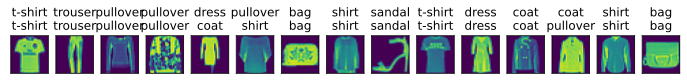

In [45]:
for X,y in test_iter: # 取第一个test_iter
    break
true_labels = d2lzh.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2lzh.get_fashion_mnist_labels(net(X).argmax(axis = 1).asnumpy())
titles = [true +'\n'+ pred for true,pred in zip(true_labels,pred_labels)]

d2lzh.show_fashion_mnist(X[0:15],titles[0:15])